In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

### Delta Based Control Variate Variance Reduction ###

The control variate method is technique to reduce variance in Monte Carlo based estimates. 

It exploits information about the errors in estimates of some known quantities to reduce the error of an estimate of an unknown quantity.

In the context of option pricing, the variance in the option price estimate as the mean of the discounted payoffs of a number of Monte Carlo simulations can be reduced by considering a correlated quantity. Such a correlated quantity could be the payoff of a dynamically hedged portfolio.

The payoff at maturity of a dynamically (delta) hedged portfolio should exactly match the option payoff. Under discretization,

$$
C_{0}\exp{rT} - \sum_{i=0}^{N}{(\frac{\partial C_{t_{i}}}{\partial S} - \frac{\partial C_{t_{i-1}}}{\partial S})S_{t_{i}}\exp{\{r(T-t_{i})\}}} = C_{T} + \eta
$$

where $\eta$ is the hedging error.

Rearranging the terms 

$$
\begin {align}
C_{0}\exp{rT} &= C_{T} - \sum_{i=0}^{N-1}{\frac{\partial C_{t_{i}}}{\partial S}}(S_{t_{i+1}} - S_{t_{i}}\exp{r\Delta_{t}})\exp{\{r(T-t_{i+1})\}} + \eta \notag \\
C_{0}\exp{rT} &= C_{T} + cv_{1} +\eta \notag
\end{align}
$$

where $cv_{1}$, the delta hedge having mean 0, is called the delta based martingle control variate.

The analytical expression for hedge sentitivities for similar options are used in practical situations for valuing an option for which analytical expressions do not exists. Here we use the Black-Scholes delta as the control variate to price European options.


In [2]:
def S1_GBM(S0: float, mu: list, sigma: list, T: float, nsteps: int, nsim: int) -> list:
    '''
    S0: initial asset price
    mu: mean rate of asset return
    sigma: asset volatility
    T: time period
    n: number of steps
    nsim: number of simulation of the asset price process
    '''
    dt = T/nsteps
    dw = np.sqrt(dt)*np.random.standard_normal(size=(nsim,nsteps)) # generate the (nsim, nsteps) brownian motion sample
    dz = (mu-0.5*sigma**2)*dt + sigma*dw 
    Sn = np.exp(np.cumsum(dz, axis=1)) # generate the (nsim, nsteps) geometric brownian momtion price process    
    Sn = S0*np.concatenate((np.ones(shape=(nsim,1)),Sn), axis=1) # add the initial value

    return (Sn)

In [3]:
def BSprice(St: float, K: float, r: float, sigma: float, div: float, Tm: float, optype: str) -> float:

    d0 = sigma*np.sqrt(Tm)
    d1 = (np.log(St/K) + (r-div + 0.5*sigma**2)*Tm)/d0
    d2 = d1 - d0
    Nd1 = norm.cdf(d1)
    Nd2 = norm.cdf(d2)

    if optype == 'call':
        BSprice = St*np.exp(-div*Tm)*Nd1 - np.exp(-r*Tm)*K*Nd2
    elif optype == 'put':
        BSprice = np.exp(-r*Tm)*K*(1-Nd2) - St*np.exp(-div*Tm)*(1-Nd1)
    else: raise Exception('optype must be call or put')

    return (BSprice)

def BSdelta(St: float, K: float, r: float, sigma: float, div: float, Tm: float, optype: str) -> float:
    d0 = sigma*np.sqrt(Tm)
    d1 = (np.log(St/K) + (r-div + 0.5*sigma**2)*Tm)/d0
    d2 = d1 - d0
    Nd1 = norm.cdf(d1)

    if optype == 'call':
        BSdelta = np.exp(-div*Tm)*Nd1
    elif optype == 'put':
        BSdelta = -np.exp(-div*Tm)*(1-Nd1)
    else: raise Exception('optype must be call or put')

    return(BSdelta)

In [16]:
S=S1_GBM(100, 0.05, 0.2, 1, 3500, 750)
K=100
r=0.06
sigma=0.2
div=0.01
Tm=np.tile(np.linspace(0,1,3500+1), (750,1)) + 1E-7

delS=BSdelta(S, K, r, sigma, div, Tm, 'call')

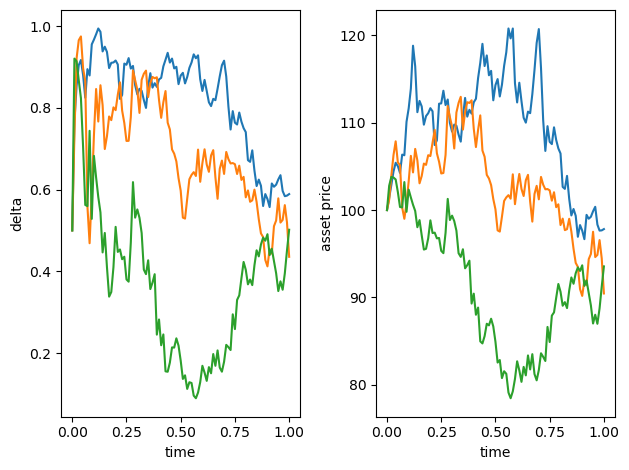

In [31]:
S=S1_GBM(100, 0.05, 0.2, 1, 100, 10)
K=100
r=0.06
sigma=0.2
div=0.01
Tm=np.tile(np.linspace(0,1,100+1), (10,1)) + 1E-7

delS=BSdelta(S, K, r, sigma, div, Tm, 'call')
fig,ax=plt.subplots(nrows=1, ncols=2)
for i in range(3):
    ax[0].plot(Tm[i,:],delS[i,:])
    ax[1].plot(Tm[i,:],S[i,:])
ax[0].set_xlabel('time')
ax[0].set_ylabel('delta')
ax[1].set_xlabel('time')
ax[1].set_ylabel('asset price')
plt.tight_layout()


In [17]:
def MCCV_Euro(S0: float, K: float, r: float, sigma: float, div: float, T: float, Nsteps: int, Nsim: int, optype: str) -> float:
    '''
    Monte Carlo estimate with control variate variance reduction

    S0: initial asset price
    K: strike price
    r: risk-free rate
    sigma: volatility
    div: continuous dividend yeild
    T: time to maturity
    Nsteps: number of time steps to maturity
    Nsim: number of independent simulations to average
    optype: option type ('call' or 'put')
    '''
    beta = -1
    mu = r-div

    dt = T/Nsteps
    nu = (r-div)-0.5*sigma**2
    dfact = r*dt + np.zeros(Nsteps)

    # parameter exception
    if ((0<r) and (0<sigma) and (0<=div)):
        pass
    else:
        raise Exception('parameter values not allowed')
    
    Smat = S1_GBM(S0=S0, mu=mu, sigma=sigma, T=T, nsteps=Nsteps, nsim=Nsim)
    Sarr = Smat[:,-1] # stock price at maturity
    Parr = Sarr-K # payoff

    if optype == 'call':
        Parr[Parr<0] = 0
        Parr = Parr
    elif optype == 'put':
        Parr[Parr>0] = 0
        Parr = -Parr
    else: raise Exception('optype must be call or put')

    # computing the delta based control variate array

    T0 = 1E-5 # not exactly zero T0
    tmat = T0 + np.tile(np.linspace(0,T, Nsteps+1), (Nsim,1))
    z = Smat[:,1:] - Smat[:,0:-1]*np.exp(mu*dt)
    delS = BSdelta(Smat[:,0:-1], K, r, sigma, div, tmat[:,0:-1], optype) # delta component
    cv = delS*z*np.exp(r*(T-tmat[:,1:]))
    CV = np.cumsum(cv, axis=1) # delta control variate array

    V0arr = np.exp(-np.sum(dfact))*(Parr + beta*CV[:,-1])
    
    return (np.mean(V0arr))

In [27]:
price = MCCV_Euro(100, 100, 0.06, 0.2, 0.0, 1, 100, 500, 'call')
print(price)

11.132896099427928


Text(0.5, 1.0, 'price convergence: MonteCarlo_deltaCV')

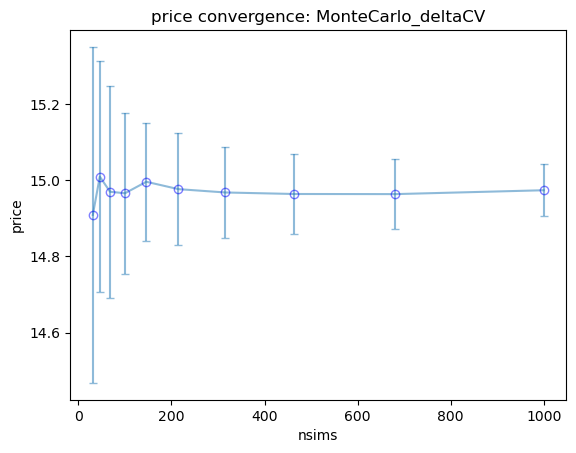

In [29]:
# calculate parameters
S0=100
K=90
r=0.06
sigma=0.2
div=0.03
T=1
Nsteps=300

NSims=np.logspace(1.5,3,10).astype(int) # simulation sizes

price_mean=[]
price_std=[]
for nsim in NSims:
    price_arr=[]
    for ntrials in range(100):
        price=MCCV_Euro(S0=S0, K=K, r=r, sigma=sigma, div=div, T=1, Nsteps=Nsteps, Nsim=nsim, optype='call') # Monte Carlo with antithetic variance reduction
        price_arr.append(price)
    price_mean.append(np.mean(price_arr))
    price_std.append(np.std(price_arr))
    
# plot
fig,ax = plt.subplots()
ax.errorbar(NSims, price_mean, yerr=price_std, marker='o', mfc='None', mec='blue', capsize=3, alpha=0.5)
ax.set_xlabel('nsims')
ax.set_ylabel('price')
ax.set_title('price convergence: MonteCarlo_deltaCV')